# Import main libraries

In [26]:

'''Main Library'''
import numpy as np
import pandas as pd

'''Visualization'''
import matplotlib.pyplot as plt
import graphviz
from graphviz import Source
from IPython.display import Image

'''Modeling'''
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

# Upload files

In [9]:
email_opened = pd.read_csv('email/email_opened_table.csv')
email_table = pd.read_csv('email/email_table.csv')
email_opened['opened'] = 1 # emails that were opened
link_clicked_table = pd.read_csv('email/link_clicked_table.csv')
link_clicked_table['clicked'] = 1
link_clicked_table['opened'] = 1# emails that were clicked on
print('Total emails sent: {}'.format(len(email_table)))
print('Total emails opened: {}'.format(len(email_opened)))
print('Total email links clicked: {}'.format(len(link_clicked_table)))

# Merging all tables
df = pd.merge(email_table, email_opened, on = 'email_id', how = 'left')
df = pd.merge(df, link_clicked_table, on = ['email_id','opened'], how = 'left')

# fill NANs with 0's
df.fillna(0,  inplace = True)

Total emails sent: 100000
Total emails opened: 10345
Total email links clicked: 2119


In [258]:
2119/100000*100

2.119

In [31]:
df.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
0,85120,short_email,personalized,2,Sunday,US,5,0.0,0.0
1,966622,long_email,personalized,12,Sunday,UK,2,1.0,1.0
2,777221,long_email,personalized,11,Wednesday,US,2,0.0,0.0
3,493711,short_email,generic,6,Monday,UK,1,0.0,0.0
4,106887,long_email,generic,14,Monday,US,6,0.0,0.0


In [12]:
# What percentage of users opened the email and what percentage clicked on the link within the email?
print('{}% of users poened the email. Of those {}% clicked on the link'.format(df['opened'].mean()*100, df[df['opened'] == 1]['clicked'].mean()*100))

10.345% of users poened the email. Of those 20.0% clicked on the link


The VP of marketing thinks that it is stupid to send emails in a random way. Based on all the information you have about the emails that were sent, can you build a model to optimize in future how to send emails to maximize the probability of users clicking on the link inside the email?

 In order for a customer to click inside a mail he must open the mail first. About 10% of the people the mail was sent to opened it. 20% of the people who opened the mail clicked inside it. The first question is, how do we increase the likelihood of a customer opening the mail? To answer this question the email version and email text features are not relevant. If a customer never opens the mail then it doesn't matter what the contents of the mail are. 

# Exploratory data analysis

## By country

### Average conversion rate for opening email and clicking inside email

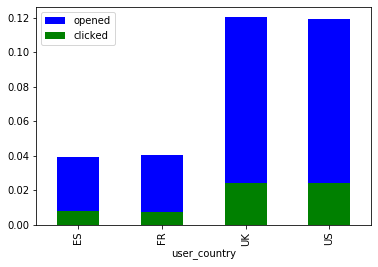

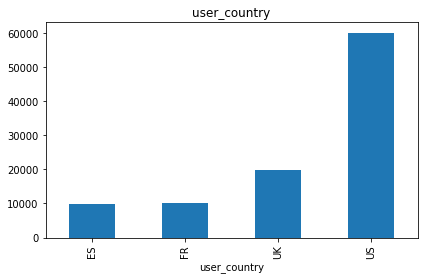

In [19]:
df.groupby('user_country')['opened'].mean().plot.bar(color = 'b')
df.groupby('user_country')['clicked'].mean().plot.bar(color = 'g')
plt.legend()
plt.show()
x = df.groupby('user_country')['email_id'].count()#/len(df)
x.plot.bar()
plt.title('user_country')
plt.tight_layout()

## By past purchases

### Average conversion rate for opening email and clicking inside email

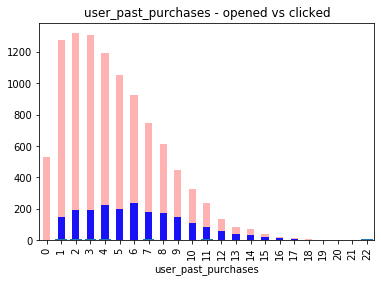

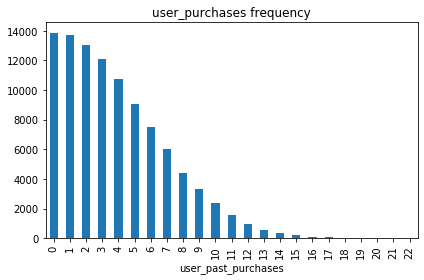

In [41]:
y = df.groupby('user_past_purchases')['clicked'].sum()
x = df.groupby('user_past_purchases')['opened'].sum()
x.plot.bar(color = 'r',alpha = 0.3)
y.plot.bar(color = 'b',alpha = 0.9)
plt.bar(x,height = 10)
plt.title('user_past_purchases - opened vs clicked')
plt.show()
x = df.groupby('user_past_purchases')['email_id'].count()#/len(df)
x.plot.bar()
plt.title('user_purchases frequency')
plt.tight_layout()

## By hour

### Average conversion rate for opening email and clicking inside email

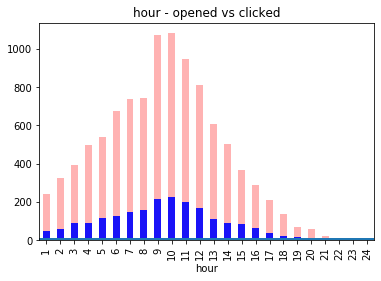

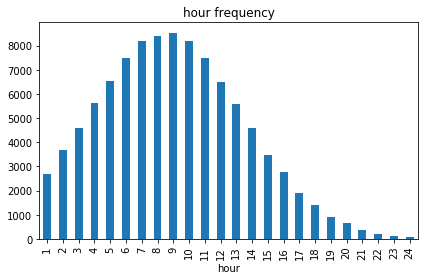

In [20]:
y = df.groupby('hour')['clicked'].sum()
x = df.groupby('hour')['opened'].sum()
x.plot.bar(color = 'r',alpha = 0.3)
y.plot.bar(color = 'b',alpha = 0.9)
plt.bar(x,height = 10)
plt.title('hour - opened vs clicked')
plt.show()
x = df.groupby('hour')['email_id'].count()#/len(df)
x.plot.bar()
plt.title('hour frequency')
plt.tight_layout()

## By weekday

### Average conversion rate for opening email and clicking inside email

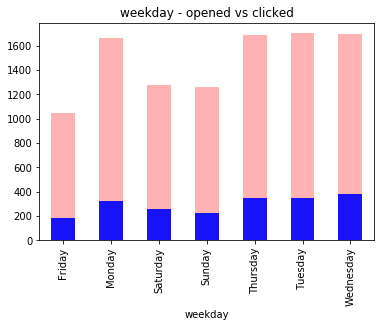

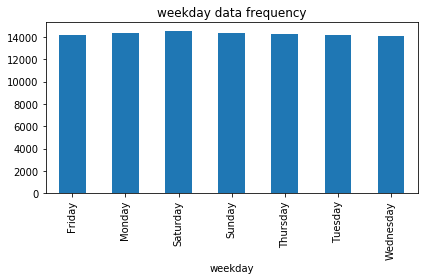

In [21]:
y = df.groupby('weekday')['clicked'].sum()
x = df.groupby('weekday')['opened'].sum()
x.plot.bar(color = 'r',alpha = 0.3)
y.plot.bar(color = 'b',alpha = 0.9)
plt.bar(x,height = 10)
plt.title('weekday - opened vs clicked')
plt.show()
x = df.groupby('weekday')['email_id'].count()#/len(df)
x.plot.bar()
plt.title('weekday data frequency')
plt.tight_layout()

## By email_text

### Average conversion rate for clicking inside email

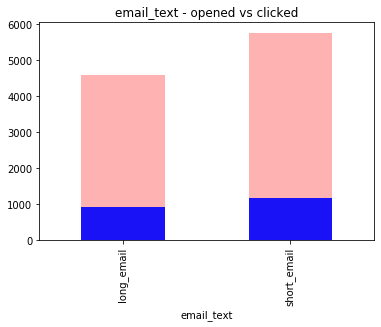

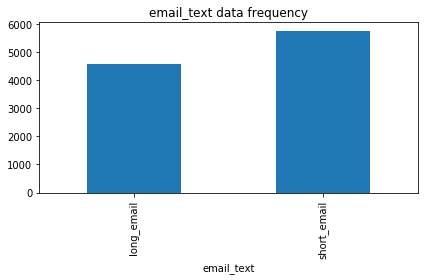

In [23]:
y = df[df['opened'] == 1].groupby('email_text')['clicked'].sum()

x.plot.bar(color = 'r',alpha = 0.3)
y.plot.bar(color = 'b',alpha = 0.9)
plt.bar(x,height = 10)
plt.title('email_text - opened vs clicked')
plt.show()
x = df[df['opened'] == 1].groupby('email_text')['email_id'].count()#/len(df)
x.plot.bar()
plt.title('email_text data frequency')
plt.tight_layout()

## By email_version

### Average conversion rate for clicking inside email

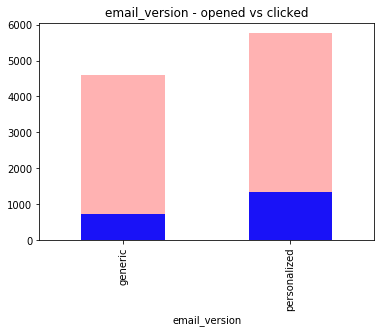

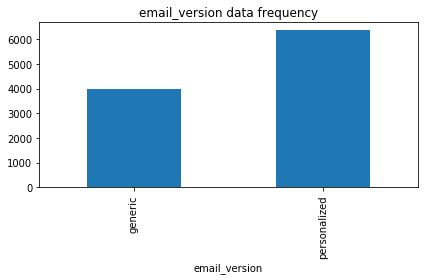

In [24]:
y = df[df['opened'] == 1].groupby('email_version')['clicked'].sum()

x.plot.bar(color = 'r',alpha = 0.3)
y.plot.bar(color = 'b',alpha = 0.9)
plt.bar(x,height = 10)
plt.title('email_version - opened vs clicked')
plt.show()
x = df[df['opened'] == 1].groupby('email_version')['email_id'].count()#/len(df)
x.plot.bar()
plt.title('email_version data frequency')
plt.tight_layout()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Conversion rate- Opening mail --> Clicking the link')

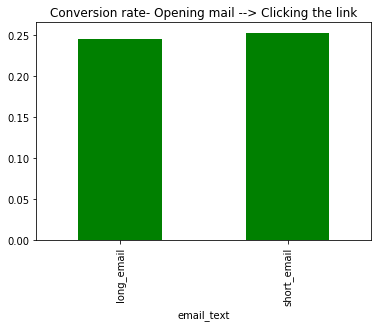

In [14]:
data_grouped_text = df[df['opened']==1].groupby("email_text")["clicked"].agg({
"did not click": lambda x: len(x[x==0]), 
"clicked": lambda x: len(x[x==1])
})
x = data_grouped_text['clicked']/data_grouped_text['did not click']
x.plot.bar(color = 'g')
plt.title('Conversion rate- Opening mail --> Clicking the link')


# Decision Tree Model

## Model for opening email 

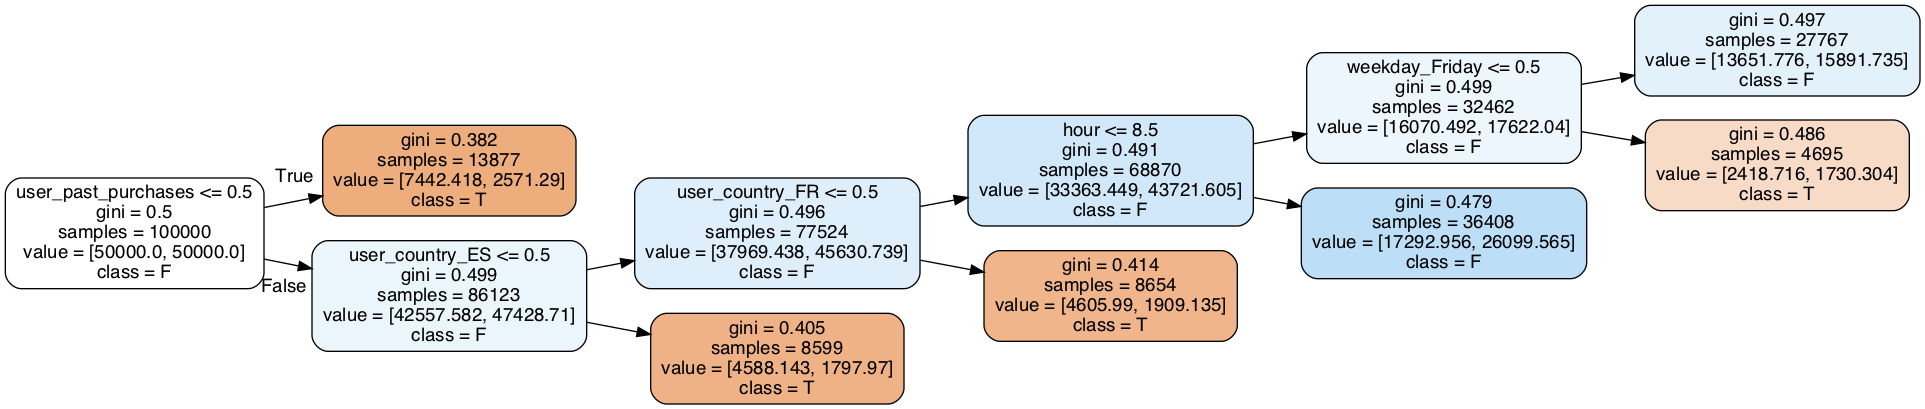

In [36]:
y = df['opened']
train = pd.get_dummies(df.drop(['email_id', 'opened', 'email_text', 'clicked','email_version'], axis = 1))
tree = DecisionTreeClassifier(max_depth = 5, class_weight = 'balanced', min_impurity_decrease = 0.001)
tree.fit(train, y)
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file="df_tree.dot", feature_names=train.columns,filled=True,class_names=['T', 'F'],
                proportion=False, rotate=True, rounded = True)
with open("df_tree.dot") as f:
    dot_graph = f.read()
s = Source.from_file("df_tree.dot")
from subprocess import check_call
check_call(['dot','-Tpng','df_tree.dot','-o','OutputFile1.png'])
print()
Image(filename='OutputFile1.png')

### Important features

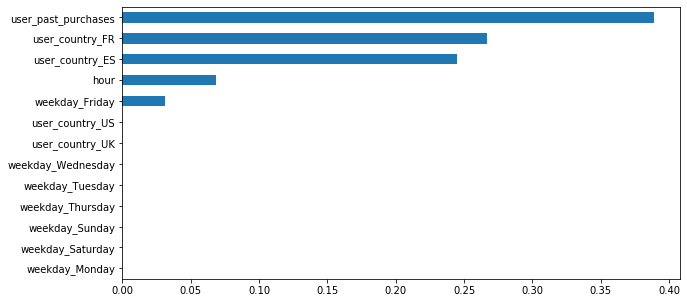

In [37]:
feat_importances = pd.Series(tree.feature_importances_, 
                             index=train.columns)
feat_importances.sort_values().plot(kind='barh', figsize = (10,5))
plt.show()

## Model for clicking inside the email

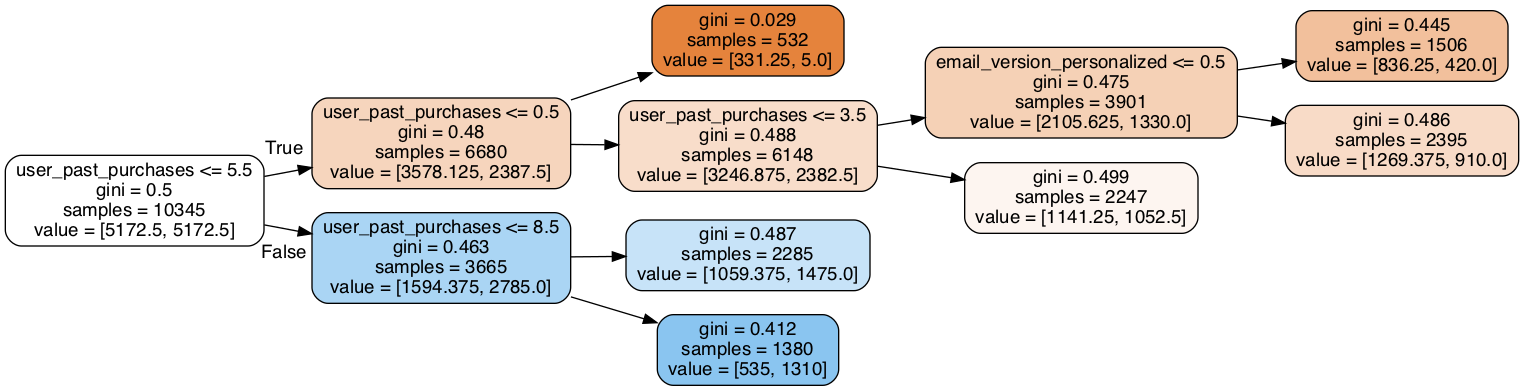

In [39]:
y = df[df['opened'] == 1]['clicked']
train = pd.get_dummies(df[df['opened'] == 1].drop(['email_id','opened', 'clicked'], axis = 1))
tree = DecisionTreeClassifier(max_depth = 5, class_weight = 'balanced', min_impurity_decrease = 0.001)
tree.fit(train, y)
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file="df_tree.dot", feature_names=train.columns,filled=True,
                rotate=True, rounded = True)
with open("df_tree.dot") as f:
    dot_graph = f.read()
s = Source.from_file("df_tree.dot")
from subprocess import check_call
check_call(['dot','-Tpng','df_tree.dot','-o','OutputFile1.png'])
Image(filename='OutputFile1.png')

### Important features

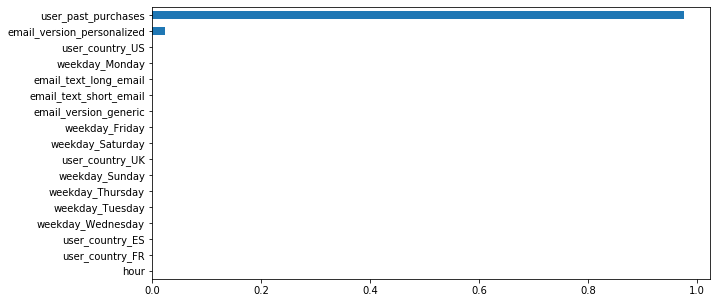

In [40]:
feat_importances = pd.Series(tree.feature_importances_, 
                             index=train.columns)
feat_importances.sort_values().plot(kind='barh', figsize = (10,5))
plt.show()

# Conclusions

## % increase in conversion if user_purchase > 1

### Opening email

In [121]:
(df['opened'].mean() - df[df['user_past_purchases'] > 0]['opened'].mean())/df['opened'].mean()*100

-10.14179608584925

### Clicking inside mail

In [125]:
df1 = df[df['opened'] == 1]
(df1['clicked'].mean() - df1[df1['user_past_purchases'] > 0]['clicked'].mean())/df1['clicked'].mean()*100

-5.319474166921426